In [12]:
import sys
sys.path.append(r"C:\Users\Artem\Desktop\vs code project\SARIMA_for_git\src")
import matplotlib.pyplot as plt
import importlib
importlib.reload(importlib.import_module('utils'))
import utils as utils
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [13]:
train, test, ex_tr, ex_test = utils.load_data()

Данные загружены!


In [15]:
utils.monitoring_callback.iteration = 1
model = SARIMAX(
    train,
    exog = ex_tr,
    order = (0,0,2),
    seasonal_order = (1,1,0,24),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(method='lbfgs', disp=True, maxiter=1000, callback=utils.monitoring_callback)  
print(results.summary())

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29


c:\Users\Artem\PycharmProjects\pythonProjectNaychka\.venv\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3016: RuntimeWarning: divide by zero encountered in divide
  return self.params / self.bse


                                      SARIMAX Results                                      
Dep. Variable:                   total load actual   No. Observations:                14592
Model:             SARIMAX(0, 0, 2)x(1, 1, [], 24)   Log Likelihood             -124087.512
Date:                             Fri, 26 Sep 2025   AIC                         248251.025
Time:                                     23:15:15   BIC                         248539.252
Sample:                                 12-01-2016   HQIC                        248346.799
                                      - 08-01-2018                                         
Covariance Type:                               opg                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    1.795e-07         -0       -inf      0.000    1.79e-07 

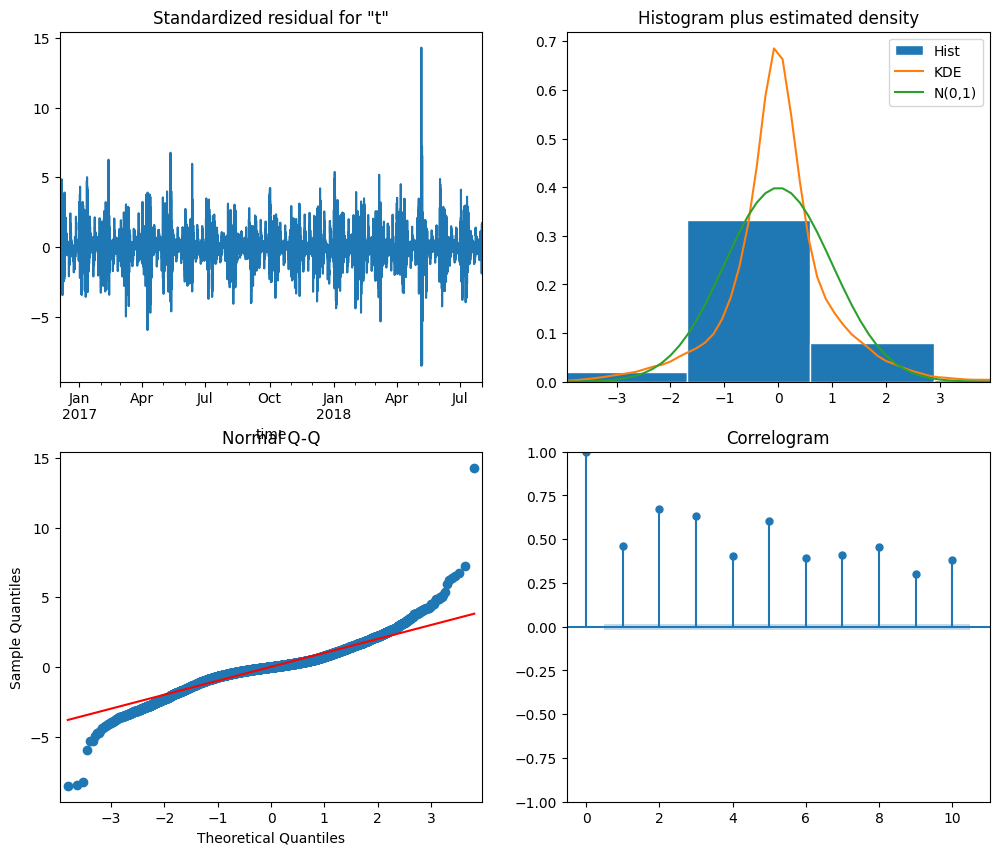

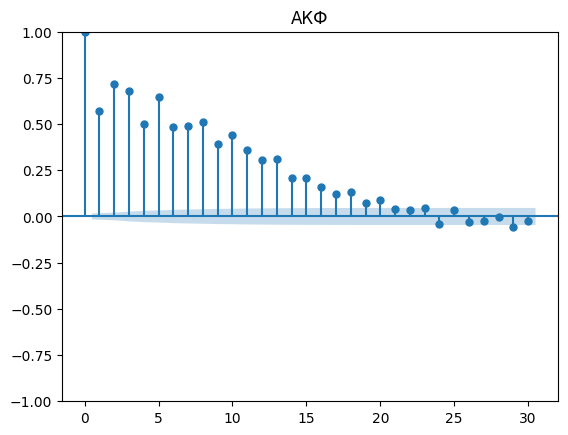

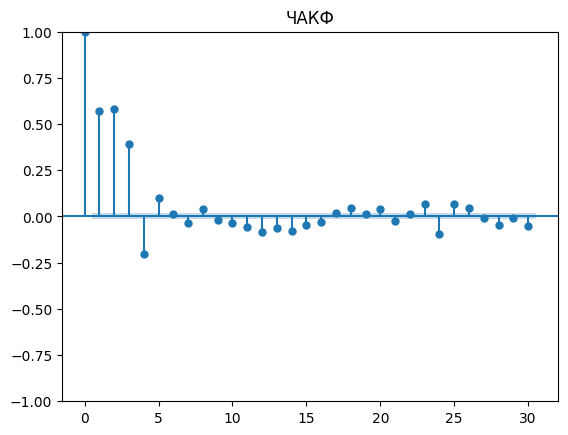

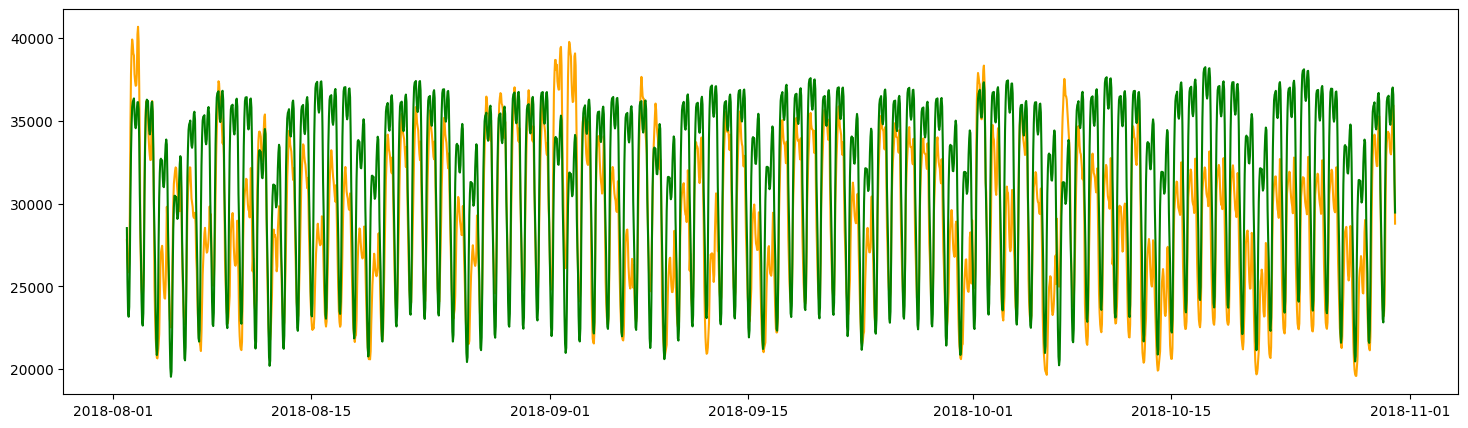

In [16]:
results.plot_diagnostics(figsize=(12,10))
plt.show()
utils.corralelogramm(results.resid)
# --- Прогноз ---
n_test = len(ex_test)
forecast = results.get_forecast(steps=n_test, exog=ex_test)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
# --- Визуализация ---
plt.figure(figsize=(18,5))
#plt.plot(train.index, train, label="Train")
plt.plot(test[:24*90].index, test[:24*90], label="Исходный ряд", color="orange")
plt.plot(test[:24*90].index, forecast_mean[:24*90], label="Прогноз", color="green")

Метрика MAE: 3360.7079492238954


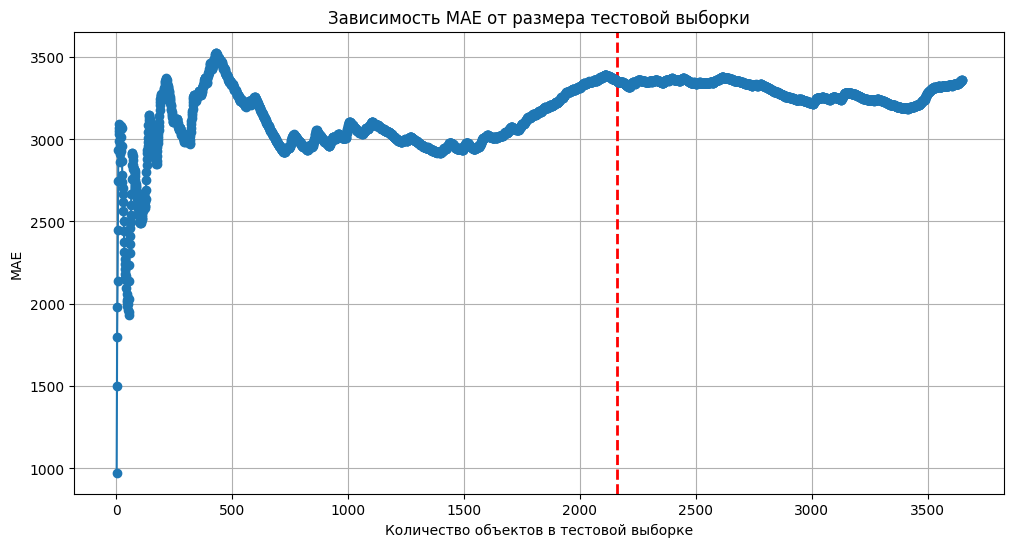

Метрика R2_score: 0.15446013245534207


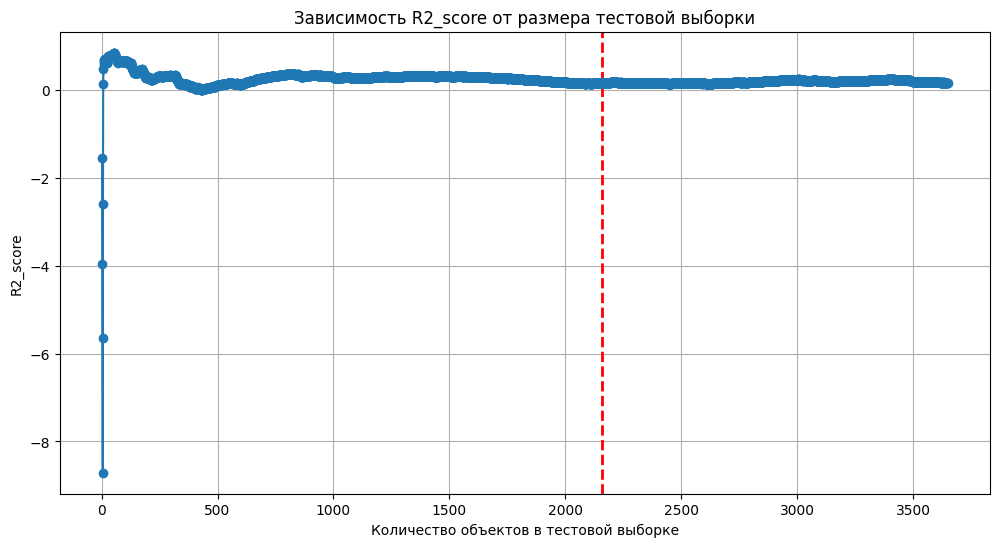

Метрика MAPE: 0.1212525991721416


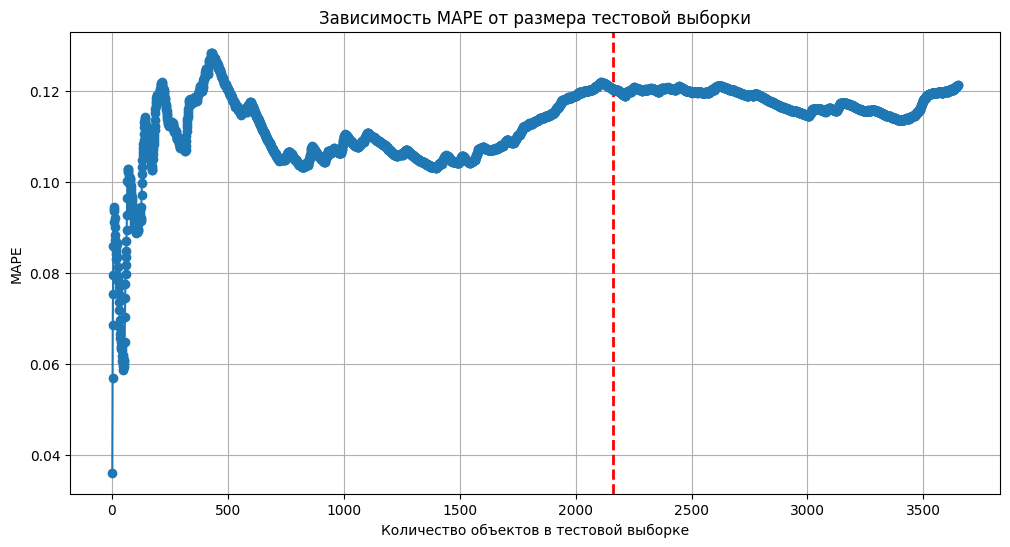

In [18]:
mae, r2_score, mape = utils.metrics(test, forecast_mean)